In [1]:
library(Seurat)
library(ggplot2)
library(data.table)
library(dplyr)
library(reshape2)

options(repr.plot.width=12, repr.plot.height=5)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.7.3 but the current
version is 1.7.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




In [6]:
# renv::load("/project/CAclust_scripts/CAclust_paper/2024_NAR_renv/")
library(Seurat)
#library(SCP)
library(SeuratData)
library(SeuratDisk)
library(ggplot2)
library(tradeSeq)
suppressMessages({
    library(Seurat)
    library(SingleCellExperiment)
    library(slingshot)
    library(RColorBrewer)
    #library(monocle3, lib.loc = '/pkg/R-4.1.0-0/lib/R/library')
    library(ComplexHeatmap)
    library(dichromat)
    library(clusterProfiler)
    library(org.Hs.eg.db)
    library(dplyr)
    library(ggplot2)
    library(ggsignif)
    options(repr.plot.width=12, repr.plot.height=5)
    # library(SeuratWrappers, lib.loc = '/pkg/R-4.1.0-0/lib/R/library') #remotes::install_github('satijalab/seurat-wrappers')
})

In [7]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: Rocky Linux 9.5 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /sc-projects/sc-proj-cc14-ag-keller-uvm/.conda/envs/RNAseq/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] tradeSeq_1.20.0             ggsignif_0.6.4             
 [3] org.Hs.eg.db_3.20.0         AnnotationDbi_1.68.0       
 [5] clusterProfiler_4.14.6      dichromat_2.0-0.1     

In [2]:
indir = '../AnalysisRes-chip4-merged-Feb2024'
outdir = "./"
dir.create(outdir)

Warning message in dir.create(outdir):
“'AnalysisRes-chip4-merged-Feb2024' already exists”


In [3]:
anx1 = read.csv('../../exdo//lib15_chip4-merged//lib15-chip4//CellBarcodes//comm.ANX5-labeled_whitelist.txt', sep = '\t', header = F)
anx1 = anx1[, c(1,3)]
colnames(anx1) = c('CellBarcodes/chi', 'Count')
anx1$Sample = 'lib15-chip4'

# casbs = list.files('../exdo//lib15_chip4-casb-merged//lib15-chip4-casb//CellBarcodes/', pattern = 'comm*', full.names = T)
casbs = list.files('../exdo//lib15_chip4_Nov2023/lib15-chip4-casb/CellBarcodes/', pattern = 'comm*', full.names = T)
casb1 = data.frame()
for (f in casbs){
    temp = read.csv(f, sep = '\t', header = F)
    temp = temp[,c(1,3)]
    sample = stringr::word(f, -1, -1, '//')
    sample = gsub('comm.', '', sample)
    sample = gsub('_whitelist.txt', '', sample)
    colnames(temp) = c('CellBarcodes', 'Count')
    temp$Sample = sample
    casb1 = rbind(casb1, temp)
}
    


In [4]:
data = Read10X(data.dir = file.path ('04.Matrix'), gene.column = 1)
cat('#Number of cells in endogeneous library', ncol(data), '\n')

#Number of cells in endogeneous library 10594 


In [5]:
head(colnames(data))

[1] "CELL7770_N1" "CELL650_N3"  "CELL5803_N1" "CELL1389_N5" "CELL8966_N1"
[6] "CELL388_N5"

In [5]:
cellist = read.csv( '03.M280UMI_stat//PL2305190346_barcodeTranslate.txt', sep = '\t', header = FALSE)
cat('# Number of annotated cell barcodes in endogeneous library', nrow(cellist), '\n')
colnames(cellist) = c('CellBarcodes', 'Cell')

cat('# Number of detected cell barcodes in CASB library', nrow(casb1), '\n')


# Number of annotated cell barcodes in endogeneous library 19557 
# Number of detected cell barcodes in CASB library 2967835 


In [6]:
## group of high
## Get the intersetion of CBs in CASB library and endogeneous library
cbdf = merge(casb1, cellist, by = 'CellBarcodes')
cat('# Number of intersected cell barcodes in both endogeneous and CASB library', nrow(cbdf), '\n')

joint.cbs = unique(cbdf$CellBarcodes)
cat('# Number of unique intersected CBs ', length(joint.cbs))

# Number of intersected cell barcodes in both endogeneous and CASB library 279240 
# Number of unique intersected CBs  19556

In [7]:
# dim(casb1[casb1$Sample == 'Sample',])
# unique(casb1$Sample)
# head(casb1[casb1$Sample == 'Sample',])
cellist = cellist[cellist$CellBarcodes %in% joint.cbs,]
idx = colnames(data) %in%  cellist[,2]
data = data[,idx]
cbdf = cbdf[cbdf$CellBarcodes %in% joint.cbs,]

In [9]:
# hto = reshape(cbdf[, 1:3], idvar = 'Sample', timevar = 'CellBarcodes', direction = 'wide')

# colnames(hto) = gsub('Count.', '', colnames(hto))
# rownames(hto) = hto$Sample
# hto = hto[, 2:ncol(hto)]

# hto[is.na(hto)] = 0
# saveRDS(hto,file.path(outdir, 'casb_merged_hto.rds'))
hto = readRDS(file.path(outdir, 'casb_merged_hto.rds'))
hto[,colnames(hto) ==  'AACACCTGATACTACTGCCA']

[1] 501   1   1   2   3   1   1   1   1   2   1   3   1   0   0   0   0   0   0
[20]   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

### The following step duplicate the expression profile of some cells which have multiple cell barcodes

In [10]:
 # hto = readRDS(file.path(outdir, 'casb_hto.rds'))
idx = match( cellist$Cell, colnames(data))
data.umis <- data[, idx]

## rename columns by cell barcodes, or else the column names will be duplicated
colnames(data.umis) = cellist$CellBarcodes
obj = CreateSeuratObject(counts = data.umis, project = "test15-chip4")
obj$CellBarcodes = cellist$CellBarcodes
obj$Cellnames = colnames(data)[idx]

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [11]:
## create obj for casb cell barcodes and demux
idx = match(cellist$CellBarcodes, colnames(hto))
hto = hto[,idx]
colnames(hto) =  cellist$CellBarcodes
obj[["HTO"]] <- CreateAssayObject(counts = hto )

obj

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
44686 features across 19556 samples within 2 assays 
Active assay: RNA (44651 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO

## Figure S1A

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing across features

Normalizing across features

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Cutoff for HCT116-Topotecan-low : 5 reads

Cutoff for HCT116-Topotecan-high : 6 reads

Cutoff for HCT116-Daunorubicin-low : 5 reads

Cutoff for HCT116-Doxorubicin-low : 12 reads

Cutoff for HCT116-Doxorubicin-high : 6 reads

Cutoff for A549-Topotecan-high : 6 reads

Cutoff for A549-Topotecan-low


 Doublet Negative  Singlet 
    8941      285    10330 

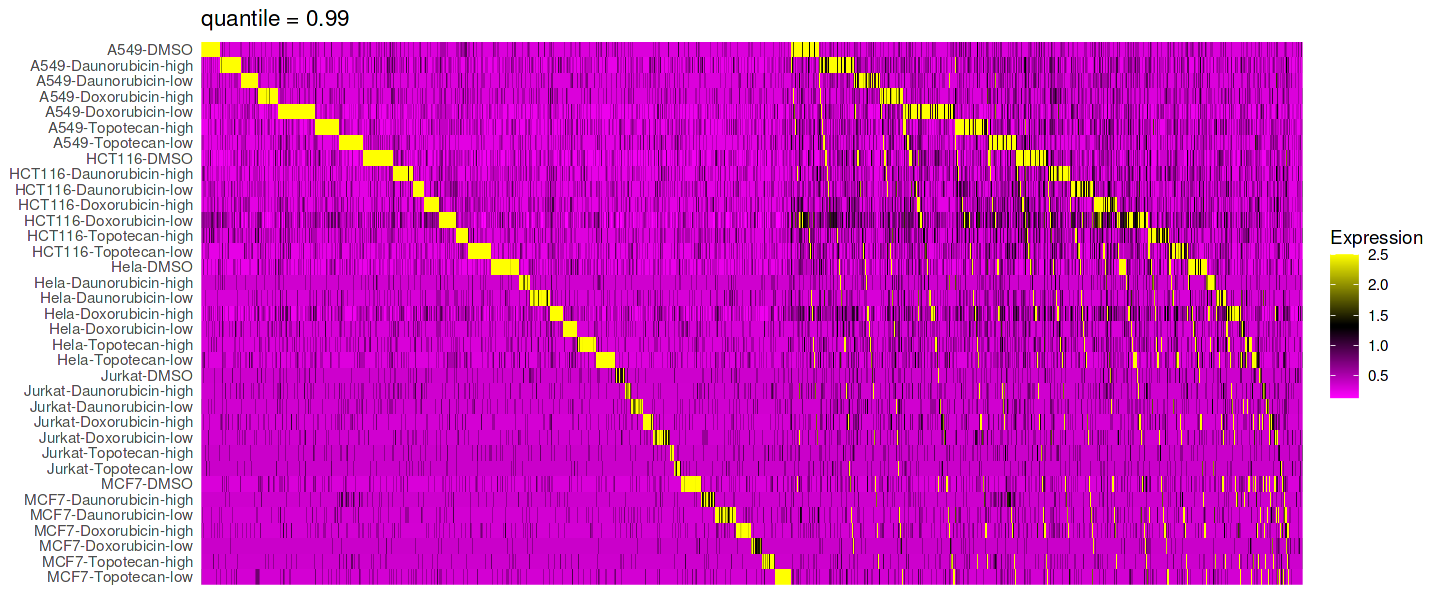

In [12]:
# hto = Matrix::sparseMatrix(hto)

obj[["HTO"]] <- CreateAssayObject(counts = hto )

obj[["pseudoHTO"]] <- CreateAssayObject(counts = hto + 1)

suppressWarnings({
    sobj1 = NormalizeData(obj, assay = "HTO", normalization.method = "CLR")
sobj1 = NormalizeData(sobj1, assay = "pseudoHTO", normalization.method = "CLR")
sobj1 = HTODemux(sobj1, assay = "pseudoHTO", positive.quantile = 0.99 )

# sobj2 = HTODemux(obj, assay = "HTO", positive.quantile = 0.99)
        })
# sobj1$HTO_classification.global = sobj1$pseudoHTO_classification.global

suppressWarnings({
    HTOHeatmap(sobj1, assay = "pseudoHTO") + labs(title = 'quantile = 0.99')
    
    })
ggsave(file.path(outdir, 'merged_pseudoHTOq0.99.pdf'), width = 10, height = 5)
ggsave(file.path(outdir, 'merged_pseudoHTOq0.99.png'), width = 10, height = 5)


colnames(sobj1@meta.data) = gsub('pseudoHTO_', 'HTO_', colnames(sobj1@meta.data))

table(sobj1$HTO_classification.global)
# table(sobj2$HTO_classification.global)


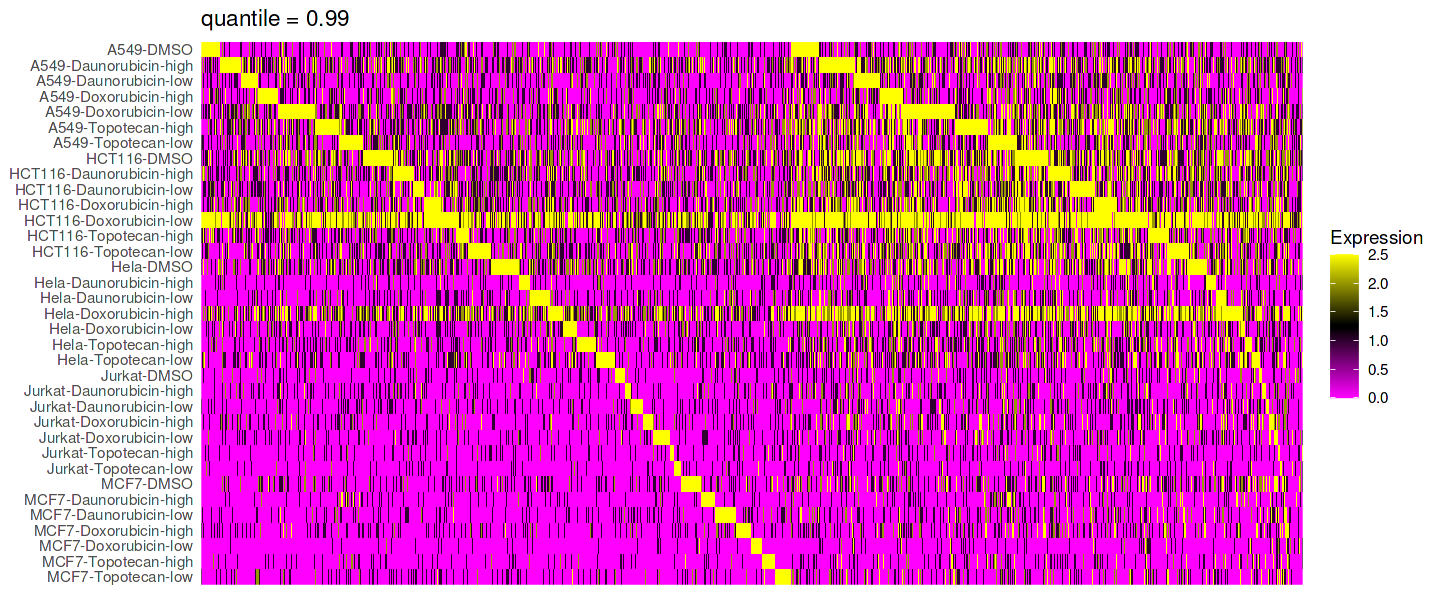

In [18]:
obj$HTO_classification.global = sobj1$HTO_classification.global
HTOHeatmap(obj, assay = "HTO") + labs(title = 'quantile = 0.99' )
ggsave(file.path(outdir, 'heatmap_hto_unnormalized.png'), width = 12, height = 8)
ggsave(file.path(outdir, 'heatmap_hto_unnormalized.pdf'), width = 12, height = 8)

In [19]:
colnames(sobj1@meta.data)

[1] "orig.ident"                "nCount_RNA"               
 [3] "nFeature_RNA"              "CellBarcodes"             
 [5] "Cellnames"                 "nCount_HTO"               
 [7] "nFeature_HTO"              "nCount_pseudoHTO"         
 [9] "nFeature_pseudoHTO"        "HTO_maxID"                
[11] "HTO_secondID"              "HTO_margin"               
[13] "HTO_classification"        "HTO_classification.global"
[15] "hash.ID"

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


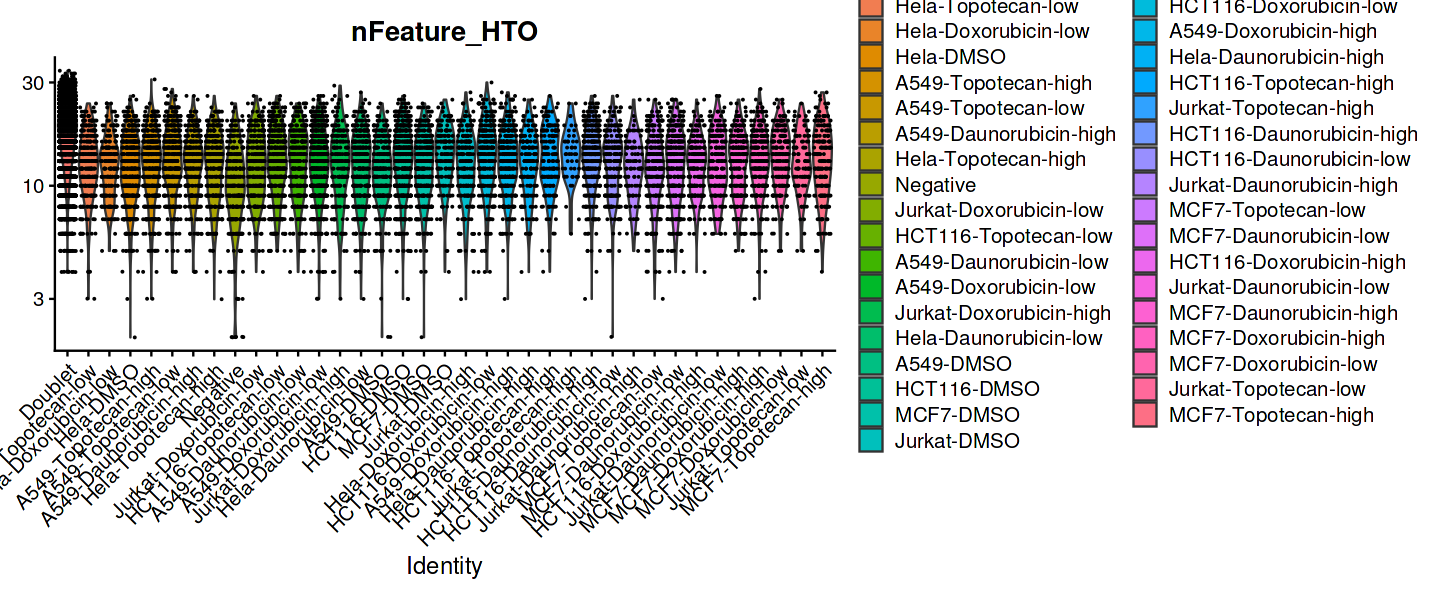

In [20]:
VlnPlot(sobj1, features = c( 'nFeature_HTO'), pt.size = 0.05, log = TRUE)
ggsave(file.path(outdir, 'nfeatures_hto_violin_doublets.png'), width = 14, height = 7)
ggsave(file.path(outdir, 'nfeatures_hto_violin_doublets.pdf'), width = 14, height = 7)

In [ ]:
VlnPlot(sobj1, features = c( 'nCount_HTO'), pt.size = 0.05, log = TRUE)
ggsave(file.path(outdir, 'nCount_hto_violin_doublets.png'), width = 14, height = 7)
ggsave(file.path(outdir, 'nCount_hto_violin_doublets.pdf'), width = 14, height = 7)

In [56]:
myHTOHeatmap <- function(
  object,
  assay = 'HTO',
  classification = paste0(assay, '_classification'),
  global.classification = paste0(assay, '_classification.global'),
  ncells = 5000,
  singlet.names = NULL,
  raster = TRUE,
    disp.max = 2.5
) {
  DefaultAssay(object = object) <- assay
  Idents(object = object) <- object[[classification, drop = TRUE]]
  if (ncells > ncol(x = object)) {
    warning("ncells (", ncells, ") is larger than the number of cells present in the provided object (", ncol(x = object), "). Plotting heatmap for all cells.")
  } else {
    object <- subset(
      x = object,
      cells = sample(x = colnames(x = object), size = ncells)
    )
  }
  classification <- object[[classification]]
  singlets <- which(x = object[[global.classification]] == 'Singlet')
  singlet.ids <- sort(x = unique(x = as.character(x = classification[singlets, ])))
  doublets <- which(object[[global.classification]] == 'Doublet')
  doublet.ids <- sort(x = unique(x = as.character(x = classification[doublets, ])))
  heatmap.levels <- c(singlet.ids, doublet.ids, 'Negative')
  object <- ScaleData(object = object, assay = assay, verbose = FALSE)
  data <- FetchData(object = object, vars = singlet.ids)
  Idents(object = object) <- factor(x = classification[, 1], levels = heatmap.levels)
  plot <- Seurat:::SingleRasterMap(
    data = data,
    raster = raster,
    feature.order = rev(x = singlet.ids),
    cell.order = names(x = sort(x = Idents(object = object))),
    group.by = Idents(object = object),
    disp.max = disp.max
  ) + guides(color = FALSE)
  return(plot)
}

In [21]:
Idents(sobj1) <- "HTO_classification.global"
sobj.singlet <- subset(sobj1, idents = "Singlet")

# # Remove duplicated columns with same cellid
sobj.singlet = sobj.singlet[, !duplicated(colnames(sobj.singlet))]
sobj.singlet = sobj.singlet[!duplicated(rownames(sobj.singlet)), ]

dim(sobj.singlet)

[1] 44651 10330

### Decide the casb label for the cells which have more than one cell barcodes

In [23]:
metadf = sobj.singlet@meta.data
dim(metadf)
head(metadf)
head(cbdf)

[1] 10330    15

orig.ident   nCount_RNA nFeature_RNA CellBarcodes        
GATGCGCATGGCAGGTATCC test15-chip4 77157      8984         GATGCGCATGGCAGGTATCC
AATTGCGGTGGACGAAGACT test15-chip4 75319      9089         AATTGCGGTGGACGAAGACT
TGACGGCCGGGAATCGGACT test15-chip4 72204      8039         TGACGGCCGGGAATCGGACT
TTGATAGATTGGTTGAGCCG test15-chip4 71288      8207         TTGATAGATTGGTTGAGCCG
GCGAATGACTCATACCAGTC test15-chip4 71089      8060         GCGAATGACTCATACCAGTC
ACCGACATTACAATCCGGAG test15-chip4 70320      8461         ACCGACATTACAATCCGGAG
                     Cellnames   nCount_HTO nFeature_HTO nCount_pseudoHTO
GATGCGCATGGCAGGTATCC CELL4906_N1 844        16           879             
AATTGCGGTGGACGAAGACT CELL4909_N1 330        13           365             
TGACGGCCGGGAATCGGACT CELL4915_N1 708        13           743             
TTGATAGATTGGTTGAGCCG CELL4917_N1 854        13           889             
GCGAATGACTCATACCAGTC CELL4918_N1 865        13           900             
ACCGACATTACAATCCGGAG CELL4922_N1 919        18           954             
                     nFeature_pseudoHTO HTO_maxID           
GATGCGCATGGCAGGTATCC 35                 Hela-Topotecan-low  
AATTGCGGTGGACGAAGACT 35                 Hela-Doxorubicin-low
TGACGGCCGGGAATCGGACT 35                 Hela-DMSO           
TTGATAGATTGGTTGAGCCG 35                 Hela-DMSO           
GCGAATGACTCATACCAGTC 35                 Hela-DMSO           
ACCGACATTACAATCCGGAG 35                 A549-Topotecan-high 
                     HTO_secondID            HTO_margin HTO_classification  
GATGCGCATGGCAGGTATCC HCT116-Doxorubicin-low  4.792344   Hela-Topotecan-low  
AATTGCGGTGGACGAAGACT HCT116-Doxorubicin-low  3.779450   Hela-Doxorubicin-low
TGACGGCCGGGAATCGGACT HCT116-Doxorubicin-high 4.570596   Hela-DMSO           
TTGATAGATTGGTTGAGCCG Hela-Doxorubicin-high   4.625020   Hela-DMSO           
GCGAATGACTCATACCAGTC Hela-Doxorubicin-high   4.430882   Hela-DMSO           
ACCGACATTACAATCCGGAG Hela-Doxorubicin-high   4.537401   A549-Topotecan-high 
                     HTO_classification.global hash.ID             
GATGCGCATGGCAGGTATCC Singlet                   Hela-Topotecan-low  
AATTGCGGTGGACGAAGACT Singlet                   Hela-Doxorubicin-low
TGACGGCCGGGAATCGGACT Singlet                   Hela-DMSO           
TTGATAGATTGGTTGAGCCG Singlet                   Hela-DMSO           
GCGAATGACTCATACCAGTC Singlet                   Hela-DMSO           
ACCGACATTACAATCCGGAG Singlet                   A549-Topotecan-high

CellBarcodes         Count Sample                  Cell       
1 AACACCTGATACTACTGCCA 501   HCT116_Topotecan_low    CELL5750_N1
2 AACACCTGATACTACTGCCA   1   HCT116_Topotecan_high   CELL5750_N1
3 AACACCTGATACTACTGCCA   1   HCT116_Daunorubicin_low CELL5750_N1
4 AACACCTGATACTACTGCCA   2   HCT116_Doxorubicin_low  CELL5750_N1
5 AACACCTGATACTACTGCCA   3   HCT116_Doxorubicin_high CELL5750_N1
6 AACACCTGATACTACTGCCA   1   A549_Topotecan_high     CELL5750_N1

In [24]:
metadf$CellBarcodes %>% unique() %>% length()
cbdf$CellBarcodes %>% unique() %>% length()

intersect(metadf$CellBarcodes , cbdf$CellBarcodes) %>% unique() %>% length()

[1] 10330

[1] 19556

[1] 10330

In [28]:
metadf %>% filter(HTO_classification.global == 'Singlet') %>%
    group_by(Cellnames) %>%
    filter(nCount_HTO == max(nCount_HTO)) %>%
    ungroup() %>%
    filter(!duplicated(Cellnames)) -> singlet.metadf

## Figure S1B

Warning message:
“Setting row names on a tibble is deprecated.”


[1] 44651  6287

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


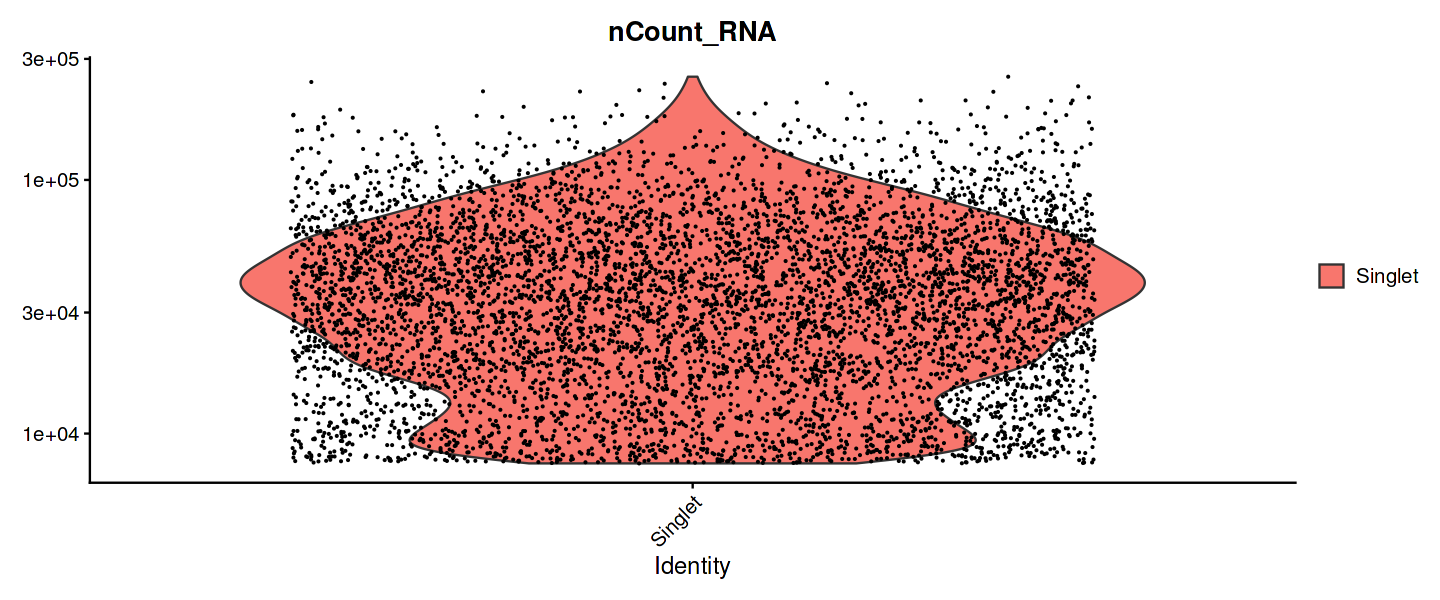

In [31]:
sobj.singlet = sobj.singlet[, colnames(sobj.singlet) %in% singlet.metadf$CellBarcodes]
rownames(singlet.metadf) = singlet.metadf$Cellnames
colnames(sobj.singlet) = singlet.metadf$Cellnames

# sobj.singlet = AddMetaData(sobj.singlet, singlet.metadf) 
dim(sobj.singlet)
Idents(sobj.singlet) <- "HTO_classification.global"



Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


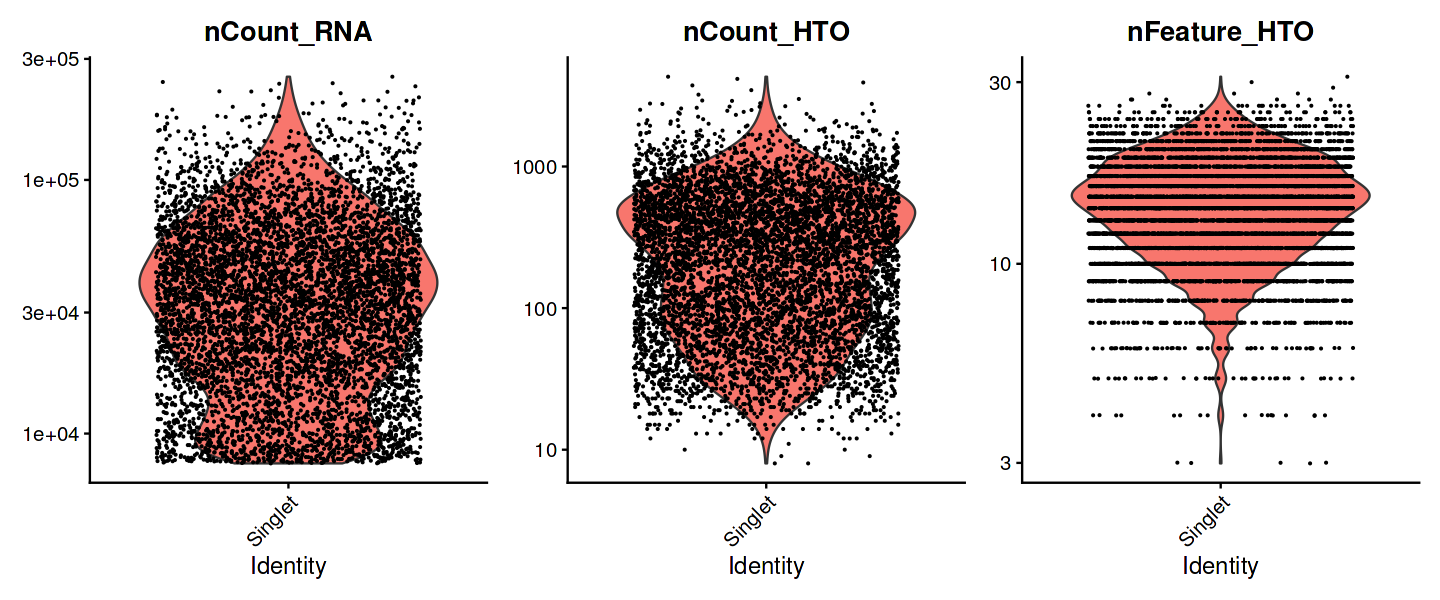

In [32]:
VlnPlot(sobj.singlet, features = c("nCount_RNA", 'nCount_HTO', 'nFeature_HTO'), pt.size = 0.1, log = TRUE)

In [34]:
head(anx1)
colnames(anx1) =c('CellBarcodes', 'ANX5', 'Chip') 
metalist = merge(anx1, singlet.metadf, by= 'CellBarcodes', all.y = T, sort=F)
metalist$ANX5[is.na(metalist$ANX5)] = 0

dim(metalist)
head(metalist)

CellBarcodes/chi     Count Sample     
1 AACACCTGATAACACTCTCC  1    lib15-chip4
2 AACACCTGATAACCTTGCGG  1    lib15-chip4
3 AACACCTGATAACGAGGTCC 55    lib15-chip4
4 AACACCTGATAACGCAATTA  1    lib15-chip4
5 AACACCTGATAACGGTTGAG  1    lib15-chip4
6 AACACCTGATAACGTCACAC  1    lib15-chip4

[1] 6287   17

CellBarcodes         ANX5 Chip        orig.ident   nCount_RNA nFeature_RNA
1 AACACCTGATACTACTGCCA  23  lib15-chip4 test15-chip4 35125      5797        
2 AACACCTGATGAGACTCGCA 258  lib15-chip4 test15-chip4 24632      4963        
3 AACACCTGATGATGCGCATG  17  lib15-chip4 test15-chip4 15324      4686        
4 AACACCTGATGGTGCGCGTA   7  lib15-chip4 test15-chip4  9605      3137        
5 AACACCTGATTAATCTAATA  33  lib15-chip4 test15-chip4 30889      6800        
6 AACACTCTCCATACCTCCAT  12  lib15-chip4 test15-chip4 21737      3755        
  Cellnames   nCount_HTO nFeature_HTO nCount_pseudoHTO nFeature_pseudoHTO
1 CELL5750_N1 519        13           554              35                
2 CELL6757_N1  64        21            99              35                
3 CELL8278_N1  36         6            71              35                
4 CELL9770_N1  21         3            56              35                
5 CELL5_N3     59        16            94              35                
6 CELL7_N2    231        12           266              35                
  HTO_maxID                HTO_secondID             HTO_margin
1 HCT116-Topotecan-low     A549-Doxorubicin-high    4.095372  
2 MCF7-Daunorubicin-high   Hela-Doxorubicin-high    1.749808  
3 Hela-Topotecan-high      HCT116-Daunorubicin-high 1.900273  
4 MCF7-Doxorubicin-high    A549-Topotecan-high      1.403271  
5 Jurkat-Daunorubicin-low  MCF7-Doxorubicin-low     2.058196  
6 HCT116-Daunorubicin-high Jurkat-Topotecan-high    3.260705  
  HTO_classification       HTO_classification.global hash.ID                 
1 HCT116-Topotecan-low     Singlet                   HCT116-Topotecan-low    
2 MCF7-Daunorubicin-high   Singlet                   MCF7-Daunorubicin-high  
3 Hela-Topotecan-high      Singlet                   Hela-Topotecan-high     
4 MCF7-Doxorubicin-high    Singlet                   MCF7-Doxorubicin-high   
5 Jurkat-Daunorubicin-low  Singlet                   Jurkat-Daunorubicin-low 
6 HCT116-Daunorubicin-high Singlet                   HCT116-Daunorubicin-high

In [42]:
idx = match( sobj.singlet$CellBarcodes, metalist$CellBarcodes)
length(idx)

[1] 6287

In [45]:
### add anxv counts to metadata
idx = match( sobj.singlet$CellBarcodes, metalist$CellBarcodes)
sobj.singlet$ANXV = metalist$ANX5[idx]
sobj.singlet$log2ANXV = log2(sobj.singlet$ANXV + 1)
sobj.singlet$log10ANXV = log10(sobj.singlet$ANXV + 1)


An object of class Seurat 
44651 features across 6287 samples within 1 assay 
Active assay: RNA (44651 features, 0 variable features)
 1 layer present: counts

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  NQO1, S100A10, FTL, MGST1, KRT18, BLVRB, PON2, PTGR1, SQSTM1, ANXA4 
	   KRT7, AKR1C3, CLU, ALDH2, RPS27L, ALDH1A1, KRT8, AKR1C2, UCHL1, TM4SF1 
	   IGFBP4, MGST3, TGFBI, NTS, ATP1B1, AKR1C1, KRT81, EPAS1, CBR1, BASP1 
Negative:  CD3D, LCP1, LCK, TRBC1, CD3G, ARHGDIB, LEF1, MYB, ITM2A, MZB1 
	   CHI3L2, BEX1, IKZF1, PTPRC, GMFG, IFI16, AIF1, ETS1, GYPC, PTPN7 
	   CDK6, IL2RG, SH2D1A, ITGA4, TRBC2, TSPAN7, ARHGAP30, LAT, NUCB2, RHOH 
PC_ 2 
Positive:  KRT19, EPCAM, CRABP2, S100A14, MAL2, RPL10P9, MDK, ADIRF, CSDE1, CLDN7 
	   ESRP1, FXYD3, AC020907.6, CLDN4, IFI30, GAL, VAMP8, MARVELD3, STARD10, EMP2 
	   TFF1, FBP1, APPBP2, TACSTD2, ASS1, SULF2, MT2A, LINC01419, RPS6KB1, PREX1 
Negative:  ALDH1A1, FXYD2, UCHL1, NTS, GABRB3, FXYD6-FXYD2, AKR1C2, SNHG5, SLC7A7, TM4SF4 
	   AKR1C3, TGFBI, AKR1B10, GPX2, SPP1, KRT7, ARL4C, F5, TM4SF1, CPLX2 
	   TM4SF20, ALDH2, TMSB4

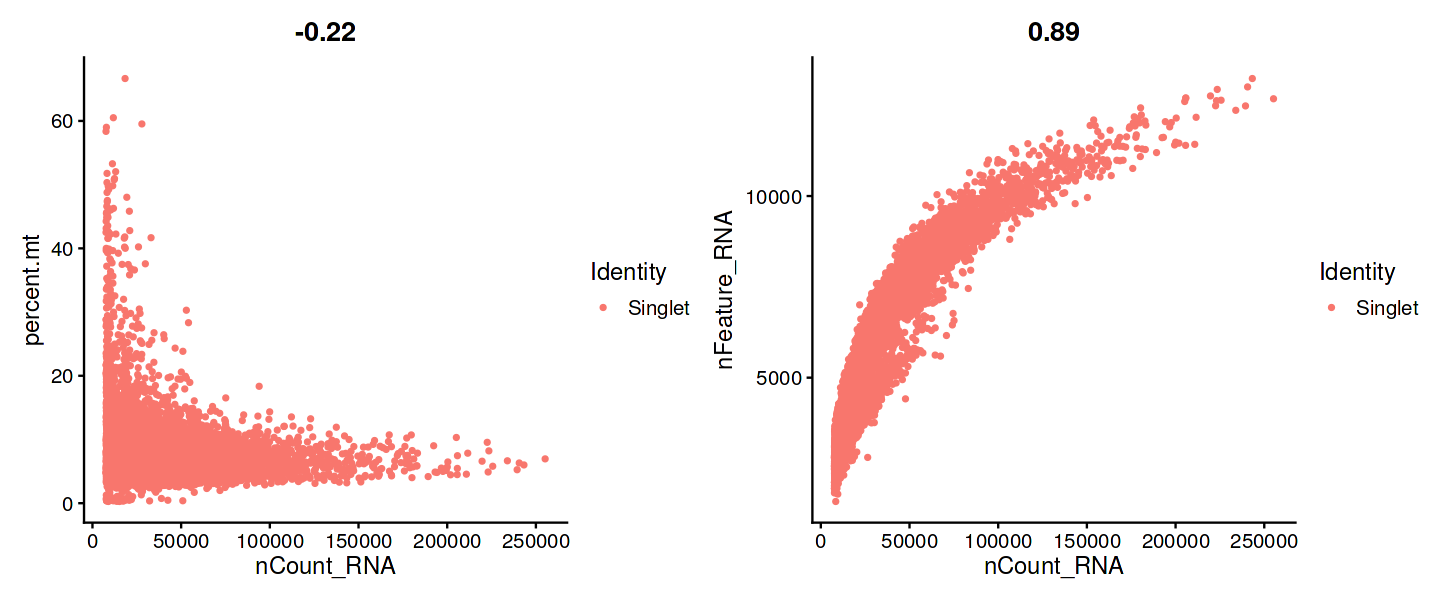

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:41:36 UMAP embedding parameters a = 0.9922 b = 1.112

17:41:36 Read 6287 rows and found 30 numeric columns

17:41:36 Using Annoy for neighbor search, n_neighbors = 30

17:41:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:41:40 Writing NN index file to temp file /scratch/local/Rtmpx7z1WN/file1e39020191b49

17:41:40 Searching Annoy index using 1 thread, search_k = 3000

17:41:47 Annoy recall = 100%

17:41:50 Commencing smooth kNN di

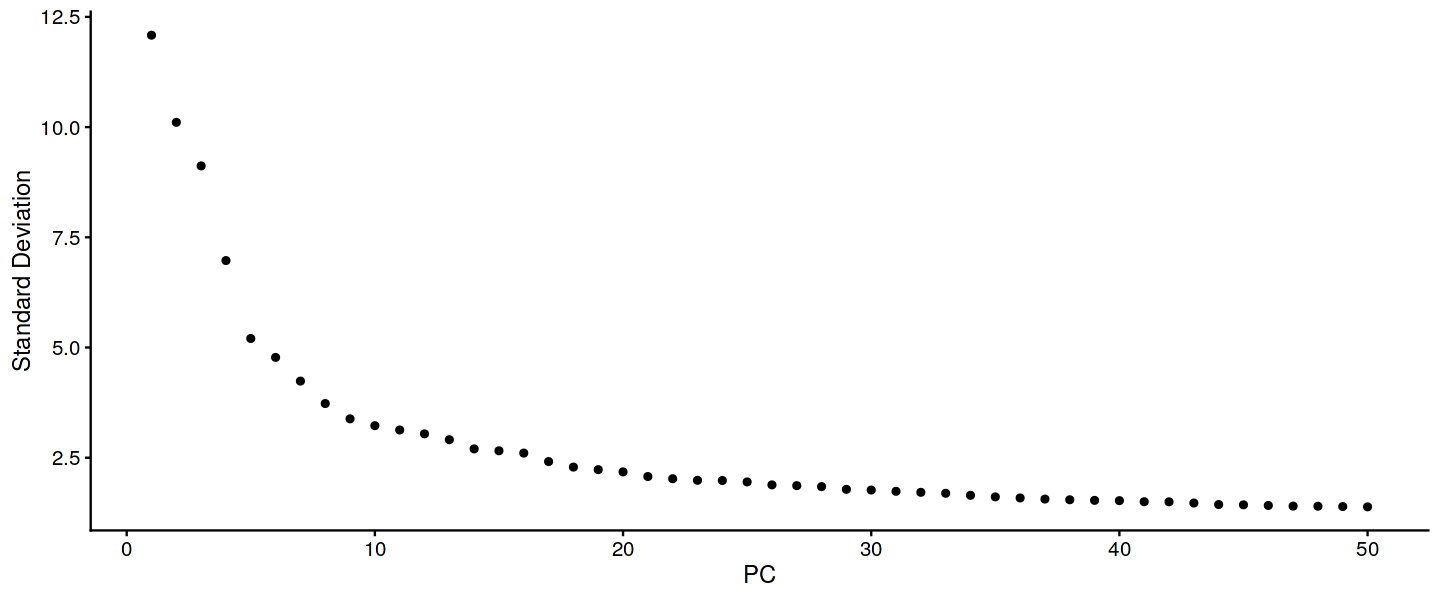

In [46]:
sobj.singlet[["percent.mt"]] <- PercentageFeatureSet(sobj.singlet, pattern = "^MT-")

# VlnPlot(sobj.singlet, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

plot1 <- FeatureScatter(sobj.singlet, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(sobj.singlet, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

# sobj <- subset(sobj, subset = nFeature_RNA > 200 & nFeature_RNA < 10000 & percent.mt < 20)

sobj.singlet

# test = readRDS('/home/zhao/02.Projects/Projects/Biclustering/02.Evaluation/SimulationDatasets/sobj_hto_mtx.rds')

# head(test)



sobj.singlet <- NormalizeData(sobj.singlet)
# Select the top 5000 most variable features
sobj.singlet <- FindVariableFeatures(sobj.singlet, selection.method = "vst", nfeatures = 2000)

# Scaling RNA data, we only scale the variable features here for efficiency
sobj.singlet <- ScaleData(sobj.singlet, features = VariableFeatures(sobj.singlet))

# Run PCA
sobj.singlet <- RunPCA(sobj.singlet, features = VariableFeatures(sobj.singlet))
# We select the top 10 PCs for clustering and tSNE based on PCElbowPlot


ElbowPlot(sobj.singlet, ndims = 50)

sobj.singlet <- FindNeighbors(sobj.singlet, reduction = "pca", dims = 1:20)
sobj.singlet <- FindClusters(sobj.singlet, resolution = 0.8, verbose = FALSE)
sobj.singlet <- RunTSNE(sobj.singlet, reduction = "pca", dims = 1:30,check_duplicates = FALSE)

sobj.singlet <- RunUMAP(sobj.singlet, dims = 1:30, seed.use = 2,n.components = 2)



# Projecting singlet identities on TSNE visualization

## Figure 2A

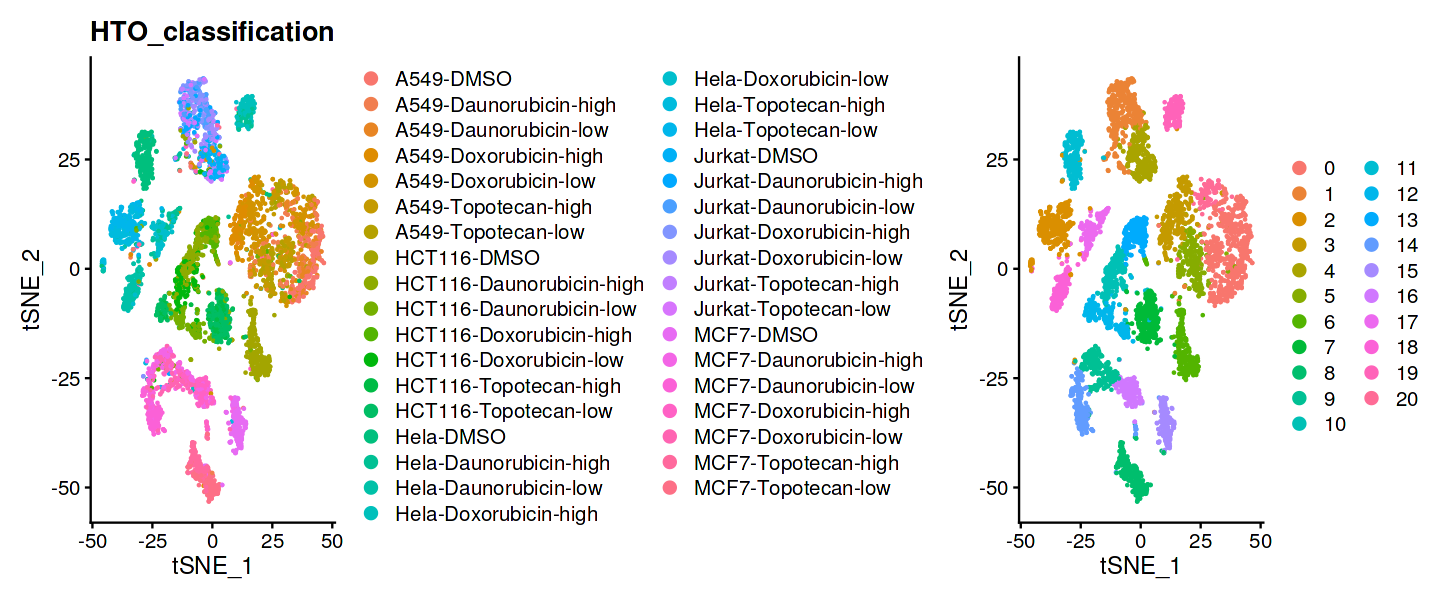

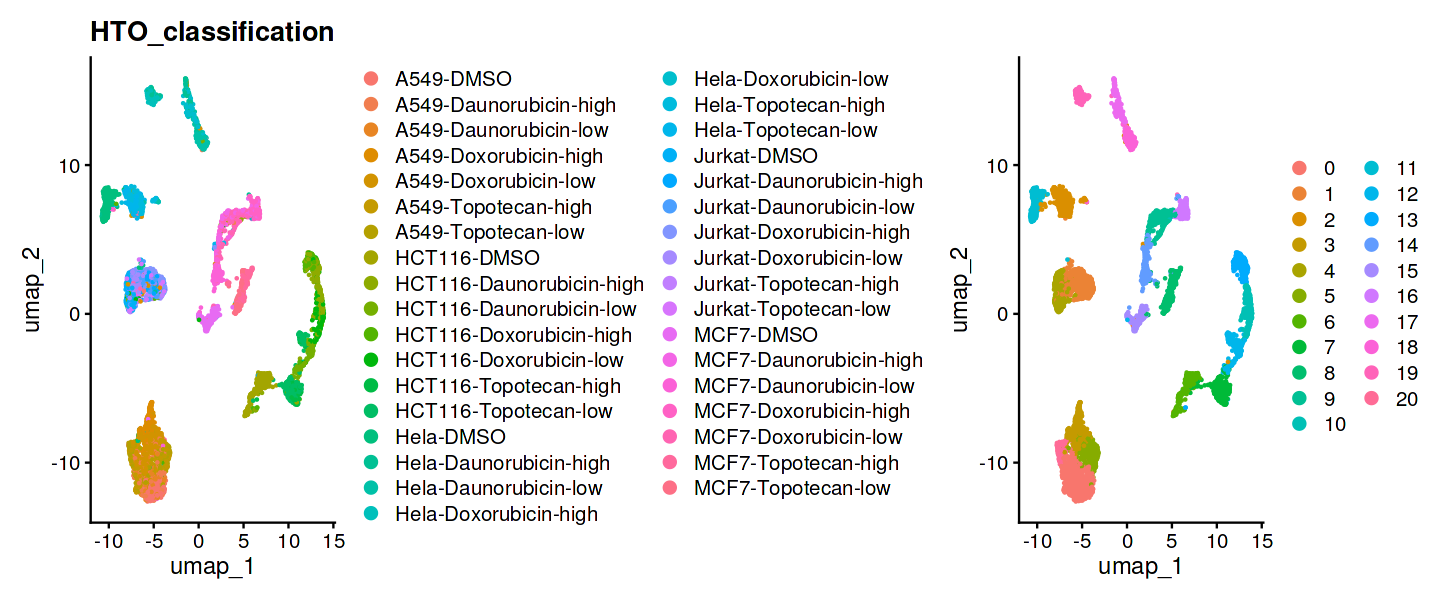

In [57]:
plot1 = DimPlot(sobj.singlet, group.by = "HTO_classification",reduction = 'tsne')
plot2 = DimPlot(sobj.singlet, reduction = "tsne")
plot1+plot2
plot1 = DimPlot(sobj.singlet, group.by = "HTO_classification",reduction = 'umap')
plot2 = DimPlot(sobj.singlet, reduction = "umap")
plot1+plot2

ggsave('umap_clustering.png', width = 15, height = 4)
ggsave('umap_clustering.pdf', width = 15, height = 4)

## Figure 2B

Warning message in brewer.pal(n = 100, name = "RdBu"):
“n too large, allowed maximum for palette RdBu is 11
Returning the palette you asked for with that many colors
”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message in brewer.pal(n = 100, name = "RdBu"):
“n too large, allowed maximum for palette RdBu is 11
Returning the palette you asked for with that many colors
”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


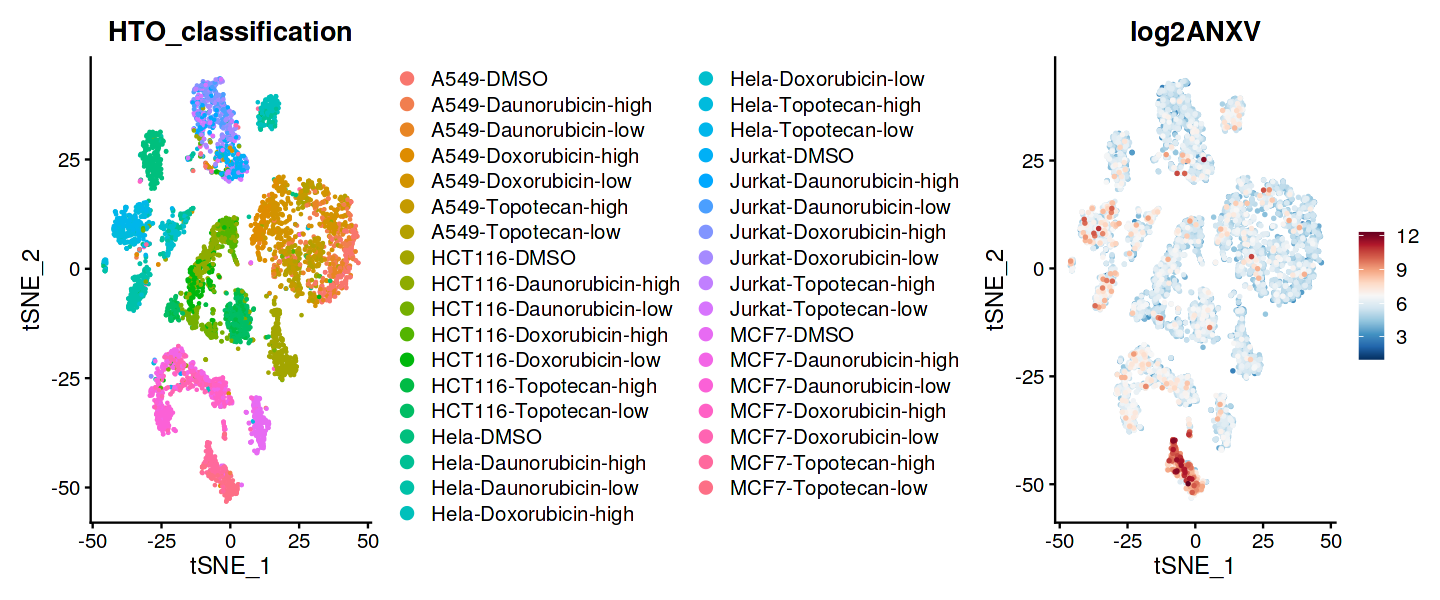

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message in brewer.pal(n = 100, name = "YlOrRd"):
“n too large, allowed maximum for palette YlOrRd is 9
Returning the palette you asked for with that many colors
”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




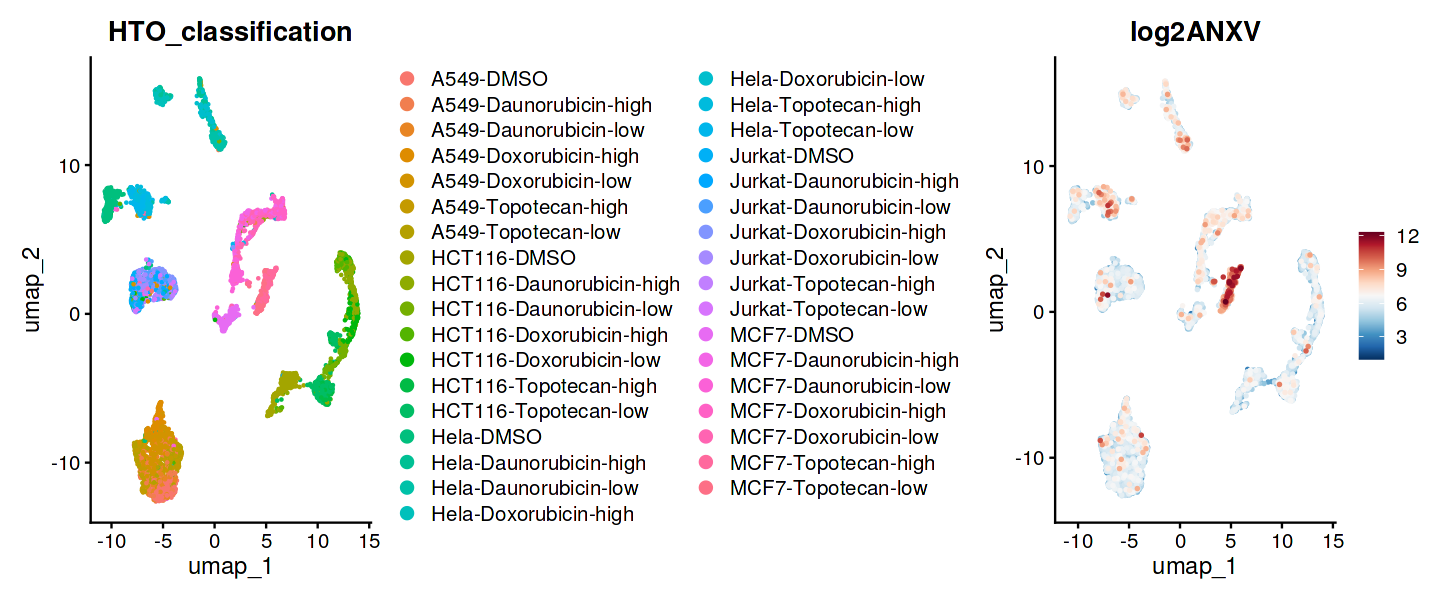

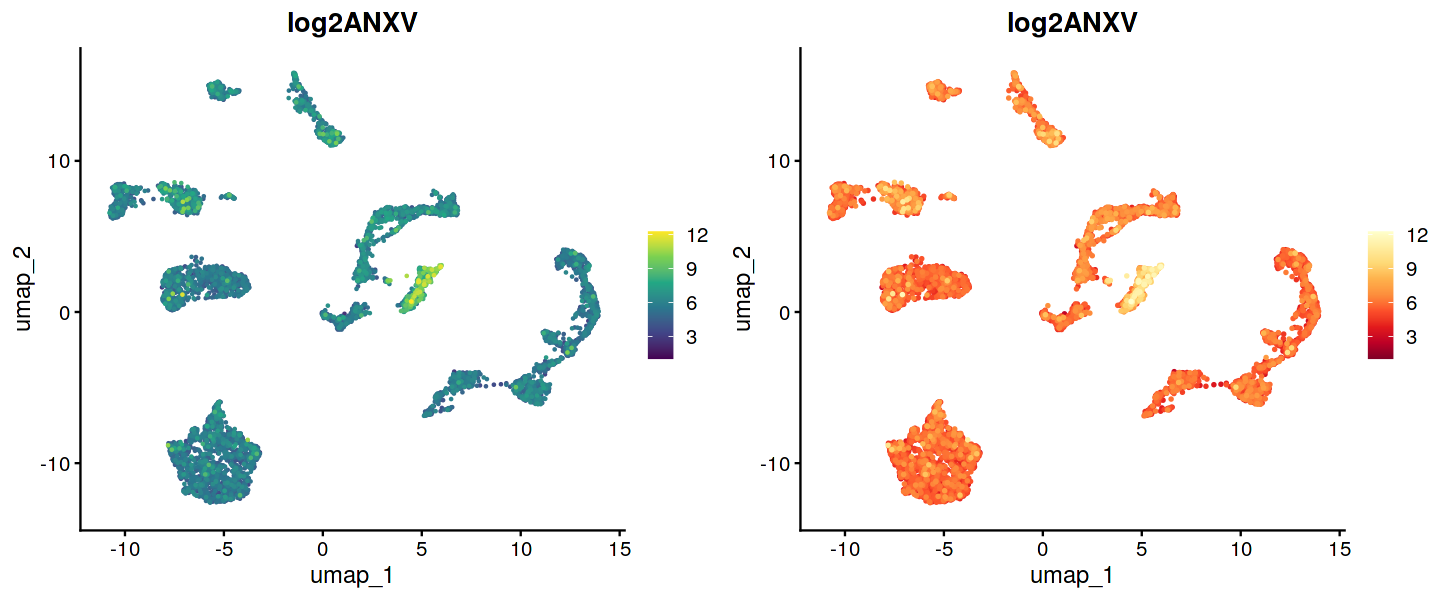

In [58]:
library(RColorBrewer)


plot3 = DimPlot(sobj.singlet, group.by = "HTO_classification", reduction = "tsne")
# new.cell.order = rownames(sobj.singlet@meta.data)[order(sobj.singlet@meta.data$ANX5, decreasing = F)]
plot4 = FeaturePlot(sobj.singlet, reduction = "tsne", 
                    features  = 'log2ANXV', order = T, 
                    pt = 0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(n = 100, name = "RdBu")))

plot3+plot4
ggsave('log2ANX5_sample_tsne.png', width = 15, height = 4)
ggsave('log2ANX5_sample_tsne.pdf', width = 15, height = 4)

library(RColorBrewer)

plot3 = DimPlot(sobj.singlet, group.by = "HTO_classification", reduction = "umap")
# new.cell.order = rownames(sobj.singlet@meta.data)[order(sobj.singlet@meta.data$ANX5, decreasing = F)]
plot4 = FeaturePlot(sobj.singlet,   features  = 'log2ANXV', 
                    order = T, pt = 0.5)+ 
    scale_colour_gradientn(colours = rev(brewer.pal(n = 100, name = "RdBu")))

plot3+plot4
ggsave('log2ANX5_sample_umap.png', width = 15, height = 4)
ggsave('log2ANX5_sample_umap.pdf', width = 15, height = 4)

plot4 = FeaturePlot(sobj.singlet,   features  = 'log2ANXV', order = TRUE) + 
    scale_color_viridis_c(limits=c(min(sobj.singlet[['log2ANXV']]), max(sobj.singlet[['log2ANXV']])), direction = 1)

plot5 = FeaturePlot(sobj.singlet,   features  = 'log2ANXV', 
                    order = T, pt = 0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(n = 100, name = "YlOrRd")))
library(gridExtra)
grid.arrange(plot4,plot5, ncol = 2)
ggsave('log2ANX5_sample_umap-ty2.png', width = 15, height = 4)
ggsave('log2ANX5_sample_umap-ty2.pdf', width = 15, height = 4)

# sobj.singlet <- FindVariableFeatures(sobj.singlet, selection.method = "vst", nfeatures = 5000)

# # Identify the 10 most highly variable genes
# top10 <- head(VariableFeatures(sobj.singlet), 10)

# # plot variable features with and without labels
# plot1 <- VariableFeaturePlot(sobj.singlet)
# plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
# plot1 + plot2

Warning message in brewer.pal(n = 100, name = "RdBu"):
“n too large, allowed maximum for palette RdBu is 11
Returning the palette you asked for with that many colors
”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


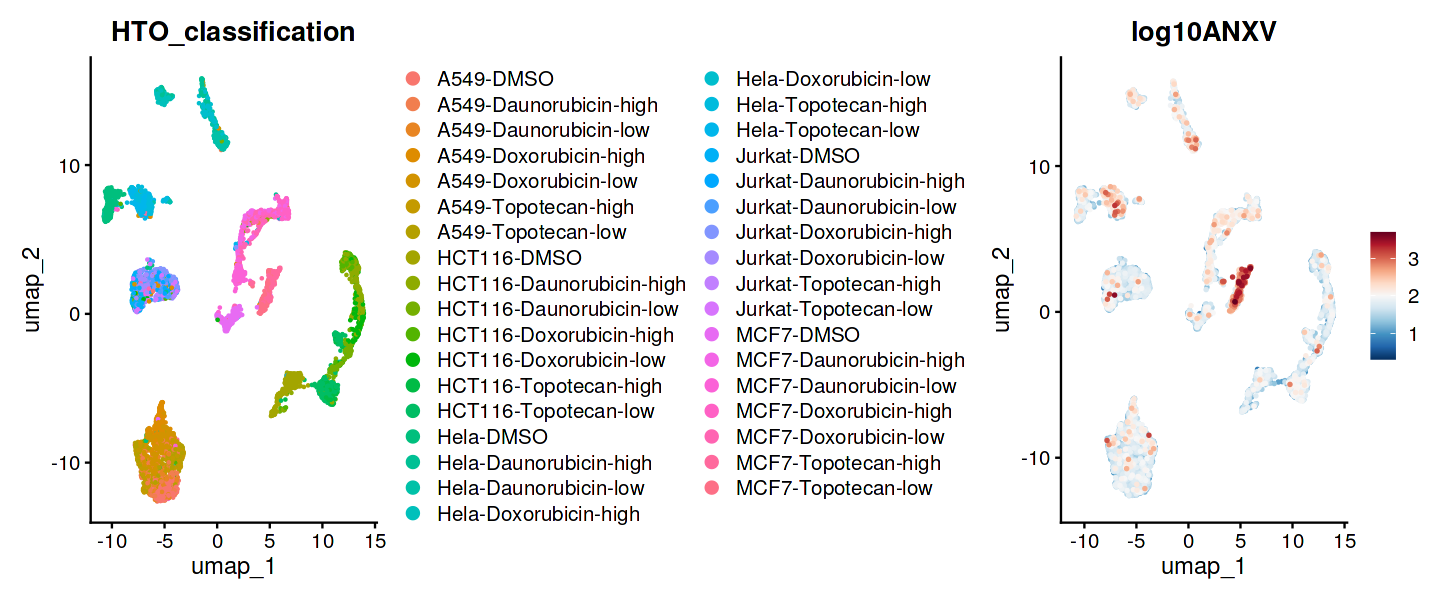

In [59]:
options(repr.plot.width=12, repr.plot.height=5)
plot3 = DimPlot(sobj.singlet, group.by = "HTO_classification", reduction = "umap")
# new.cell.order = rownames(sobj.singlet@meta.data)[order(sobj.singlet@meta.data$ANX5, decreasing = F)]
plot4 = FeaturePlot(sobj.singlet,   features  = 'log10ANXV', order = T, pt = 0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(n = 100, name = "RdBu")))

plot3+plot4
ggsave('log10ANX5_sample_umap.png', width = 15, height = 4)
ggsave('log10ANX5_sample_umap.pdf', width = 15, height = 4)


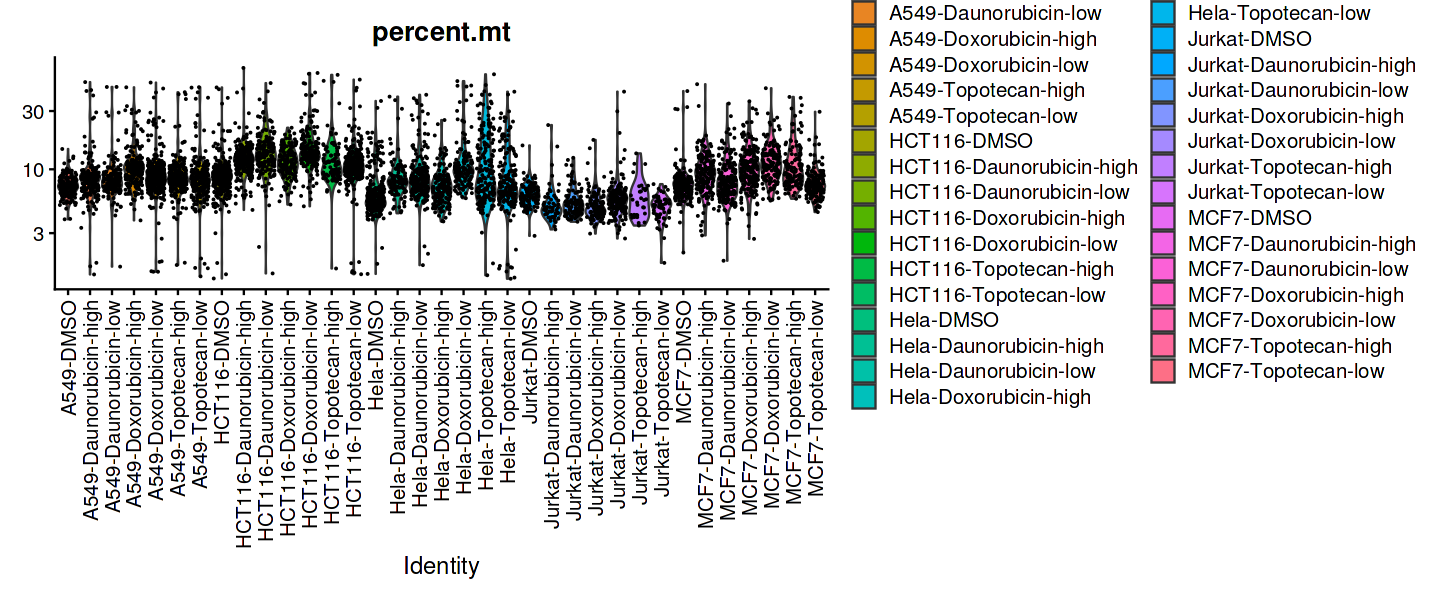

In [63]:
VlnPlot(sobj.singlet, features = c( 'percent.mt'), pt.size = 0.05, log = TRUE, group.by = 'HTO_classification') +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave(file.path(outdir, 'percent.mt_violin_sample.png'), width = 14, height = 7)
ggsave(file.path(outdir, 'percent.mt_violin_sample.pdf'), width = 14, height = 7)

In [55]:
# setwd(outdir)
saveRDS(sobj.singlet, 'pure_singlets_seurat.rds')

In [56]:
print('done')

[1] "done"


## Figure S1C

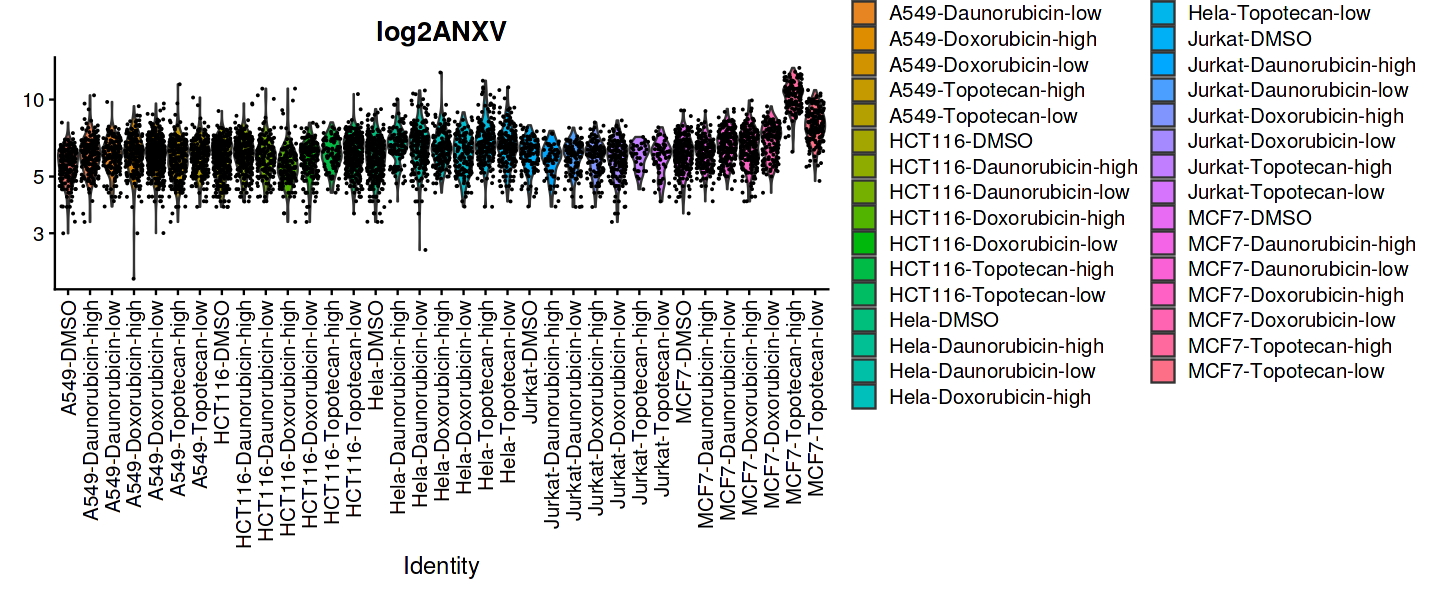

In [6]:
VlnPlot(sobj.singlet, features = c( 'log2ANXV'), pt.size = 0.05, log = TRUE, group.by = 'HTO_classification') +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [8]:
# sobj.singlet$HTO_classification